<a href="https://colab.research.google.com/github/kasidejcha/BERT_QnA/blob/main/net_rate_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from pandas import to_datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# function for mape
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
train = pd.read_csv('/content/drive/My Drive/net_rate/Data/train.csv').drop('gmv_rate',axis=1)
val = pd.read_csv('/content/drive/My Drive/net_rate/Data/val.csv').drop('gmv_rate',axis=1)
val.tail()

,date,net_rate
25,2021-07-03,0.857004
26,2021-07-04,0.849715
27,2021-07-05,0.850116
28,2021-07-06,0.851735
29,2021-07-07,0.666483


In [ ]:
# formatting for Prophet
train = train[train['date']>='2020-07-01'].reset_index(drop=True)
train_prophet = train.copy().rename(columns={'date':'ds', 'net_rate': 'y'})
train_prophet['ds'] = to_datetime(train_prophet['ds'])

In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=len(val))
future.tail()

,ds
367,2021-07-03
368,2021-07-04
369,2021-07-05
370,2021-07-06
371,2021-07-07


In [ ]:
forecast1 = model.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
367,2021-07-03,0.853017,0.803886,0.902203
368,2021-07-04,0.836946,0.789357,0.883789
369,2021-07-05,0.834487,0.783793,0.886662
370,2021-07-06,0.845223,0.794288,0.899119
371,2021-07-07,0.854791,0.808638,0.902352


In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast1)

In [ ]:
result = val.copy()
result.rename(columns={'net_rate':'actual'},inplace=True)
result['forecast'] = forecast1['yhat'][-len(val):].reset_index(drop=True)
result.set_index('date',inplace=True)
result.index = to_datetime(result.index)

In [ ]:
# Metrics
forecast = result.copy()
# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.002308
rmse,0.048043
mae,0.030298
mape,3.556350
mdae,0.018977
mdape,2.189828


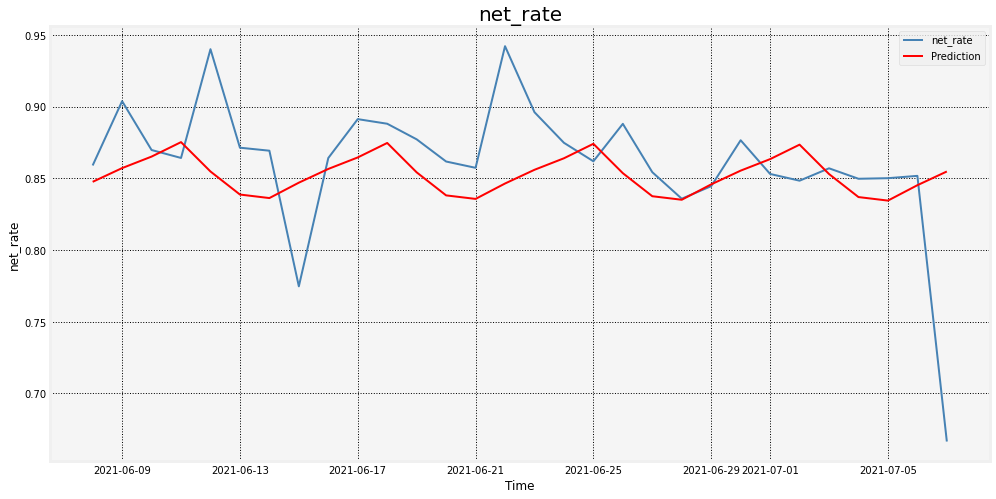

In [ ]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()